In [1]:
#
# Loading libraries
#

import numpy as np

from sklearn.datasets import fetch_openml

import daz

daz.set_daz()
daz.set_ftz()

np.random.seed(1)

def norm_dot(x, y):
    return np.dot(x,y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [2]:
#
# Fetching the dataset from server and scale 
# it for our purpose
#

# # Fetch the datasets

# mnist = fetch_openml("mnist_784")

# # Normalize the dataset
# mnist_data = mnist.data.values / np.max(mnist.data.values)

# # Get Targets
# mnist_target = mnist.target.astype(int)

# # Convert labels to binaries
# mnist_label = np.zeros((mnist_data.shape[0], 10))
# for idx in range(mnist_data.shape[0]):
#     mnist_label[idx,int(mnist.target[idx])] = 1

mnist_data = np.load("../mnist_data.np.npy")
mnist_label = np.load("../mnist_label.np.npy")

# Clean memory space of mnist
mnist = None

In [3]:
# Number of middle layer

N_y = int(200)

# Number of training samples 

N_train_sample = int(5000)

In [4]:
def y_of_x(x):
    return 0.5*(x + np.abs(x))

# The activation function for y

def y_of_x(x:np.ndarray, W_E_xy:np.ndarray = None, 
           W_I_yy:np.ndarray = None, noise = None
            ):
    
    if W_E_xy is None:
        return 0.5*(x + np.abs(x))

    if len(x.shape) == 1:
        y = np.zeros((W_E_xy.shape[0]))
    else:
        y = np.zeros((W_E_xy.shape[0], x.shape[1]))

    for t in range(20):
        input4y = np.matmul(W_E_xy, x) / np.sqrt(W_E_xy.shape[1])
        if W_I_yy is not None:
            input4y -= np.matmul(W_I_yy, (y)) / np.sqrt(W_I_yy.shape[1])
        if noise is not None:
            input4y += noise
        y += (-y + np.maximum(input4y, 0)) / np.sqrt(5.0)

    return y

def cal_fit_rate(W_E_xy:np.ndarray, 
                 data_sample:np.ndarray, target_sample:np.ndarray,
                 data_test:np.ndarray, target_test:np.ndarray):

    y = y_of_x(data_sample.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    W_yz = np.matmul(y, y.transpose())

    W_yz = np.matmul(y.transpose(), np.linalg.pinv(W_yz))

    W_yz = np.matmul(target_sample.transpose(), W_yz)
    
    
    

    y = y_of_x(data_test.transpose(), W_E_xy)

    y_tmp = np.append(y, np.ones((1,y.shape[1])), axis=0)

    y = y_tmp

    z = np.matmul(W_yz, y)

    ans = 1.0 - np.sum(np.heaviside(
                    np.absolute(z.argmax(axis=0) - target_test.argmax(axis=1)) - 0.5
                    , 0)) / float(data_test.shape[0])

    return ans

def update_w(x, w):
    
    w_local = np.copy(w)
    
    x_last = np.zeros(w.shape[1])
    y_last = np.zeros(w.shape[0])
    
    for idx in range(x.shape[0]):
        
        xt = x[idx]
        
#        noise = np.heaviside(np.random.rand(w_local.shape[0]) - 0.95, 0)
        noise = np.random.normal(size=w_local.shape[0])
    
        y = y_of_x(xt, w_local, noise=noise)

        delta_w = np.outer(y, xt)
        
        for i in range(w_local.shape[0]):
            if np.sum(w_local[i]) >= 1.0:
                delta_w[i] = np.zeros_like(delta_w[i])
                
        for i in range(delta_w.shape[1]):
            delta_w[:,i] -= np.mean(delta_w[:,i])

        w_local += 0.02 * delta_w
                    
        for i in range(w_local.shape[1]):
            if np.max(w_local[:,i]) > 1:
                w_local[:,i] /= np.max(w_local[:,i])

        for i in range(w_local.shape[0]):
            if np.max(w_local[i]) < 0:
                w_local[i] = np.zeros_like(w_local[i])
                    
              
    return w_local

In [5]:
all_results = []

for d in range(10):
    
    results = []


    for t in range(10):
        #
        # Cutting the dataset to different matices
        #

        # Copy the dataset to training and testing

        N_test = int(mnist_data.shape[0] * 0.1)

        random_list = np.arange(mnist_data.shape[0])
        np.random.shuffle(random_list)

        mnist_target_training = mnist_label[random_list[:N_train_sample]]
        mnist_data_training = mnist_data[random_list[:N_train_sample]]

        mnist_target_testing = mnist_label[random_list[(mnist_data.shape[0]-N_test):]]
        mnist_data_testing = mnist_data[random_list[(mnist_data.shape[0]-N_test):]]

        # Adding age factor for consideration

        W_E_xy = np.zeros((N_y, mnist_data.shape[1]))

        digit_train = mnist_target_training.argmax(axis=1)
        digit_test = mnist_target_testing.argmax(axis=1)

        W_E_xy_zero = update_w(mnist_data_training[digit_train==d], W_E_xy)

        W_record = [W_E_xy_zero]

        stepsize = 550
        for t in np.arange(0, N_train_sample, 550):
            w_tmp = update_w(mnist_data_training[digit_train!=d][t:t+stepsize], W_record[-1])
            W_record.append(w_tmp)

        result = []

        y_zero_0 = y_of_x(mnist_data_testing[digit_test==d].transpose(), W_E_xy_zero)
        y_zero_0_sh = y_zero_0.copy().flatten()
        np.random.shuffle(y_zero_0_sh)
        y_zero_0_sh = y_zero_0_sh.reshape(y_zero_0.shape)
        for w in W_record:
            y_zero_1 = y_of_x(mnist_data_testing[digit_test==d].transpose(), w)
            result.append(np.mean([norm_dot(y_zero_0[:,i], y_zero_1[:,i]) 
                                   for i in range(y_zero_1.shape[1])])
                          -np.mean([norm_dot(y_zero_0[:,i], y_zero_0_sh[:,i]) 
                                    for i in range(y_zero_1.shape[1])]))

        results.append(result)
        
    all_results.append(results)

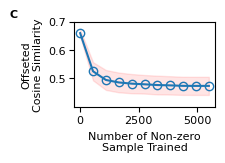

In [40]:

import matplotlib.pyplot as plt

mean_all = np.mean(all_results, axis=1)

fig = plt.figure(figsize=(5.5/2.525,3.3/2.525))
ax = fig.add_subplot(111)
ax.tick_params('x', labelsize=8, pad=3)
ax.tick_params('y', labelsize=8, pad=2)
ax.set_xticks(np.arange(0,5001,2500))
ax.set_yticks((0.5,0.6,0.7))
ax.set_ylim((0.4,0.7))
ax.set_xlabel("Number of Non-zero\nSample Trained", fontsize=8)
ax.set_ylabel("Offseted\nCosine Similarity", fontsize=8)
ax.plot(np.arange(0,11)*550, mean_all.mean(axis=0), "o-", mfc="None")
ax.fill_between(np.arange(0,11)*550, 
                 mean_all.mean(axis=0)-mean_all.std(axis=0), 
                 mean_all.mean(axis=0)+mean_all.std(axis=0), color="red", alpha=0.1, zorder=-10)


ax.text(x=-0.45,y=1.05,s="C",weight="bold",fontsize=8, transform=ax.transAxes)

plt.subplots_adjust(left=0.3,
                    bottom=0.3, 
                    right=0.95, 
                    top=0.95, 
                    wspace=0.45, 
                    hspace=0.75)
fig.savefig("Fig04_2mid2.pdf")